# Privacy-protected diagnostics of machine health
>**Research Project** : Our paper [Homomorphic Encryption as a secure PHM outsourcing solution for SMEs](https://www.sciencedirect.com/science/article/abs/pii/S0278612521001254) (Kang et. al 2021)'s partial source code <br />
**Author** : Ha Eun David Kang (haeun@mit.edu), MIT MechE PhD Candidate <br />
**Data Source** : FRED (Fiber Extrusion Device) built in MIT lab <br />
**Highlight** : [Press Release 2021 (Industry 4.0)](https://www.dongascience.com/news.php?idx=47584), Samsung Techday 2021

In [1]:
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from IPython.display import Image

Defaulting to user installation because normal site-packages is not writeable


## 1. FrED and its spool

> [FrED](https://asmedigitalcollection.asme.org/DSCC/proceedings-abstract/DSCC2017/V003T31A005/454967) is a Fiber Extrusion Device developed in our lab at MIT MechE with the intention to miniaturiaze industrial fiber extruders to make it as a great small-scale kit for manufacturing education. Take a look at our 5 year-old FrED in below. A shown, it is comprised of an extruder, a cooling zone, a laser micrometer that measures the output diameter, and a spool system that rotates to pull and collect the output fiber.

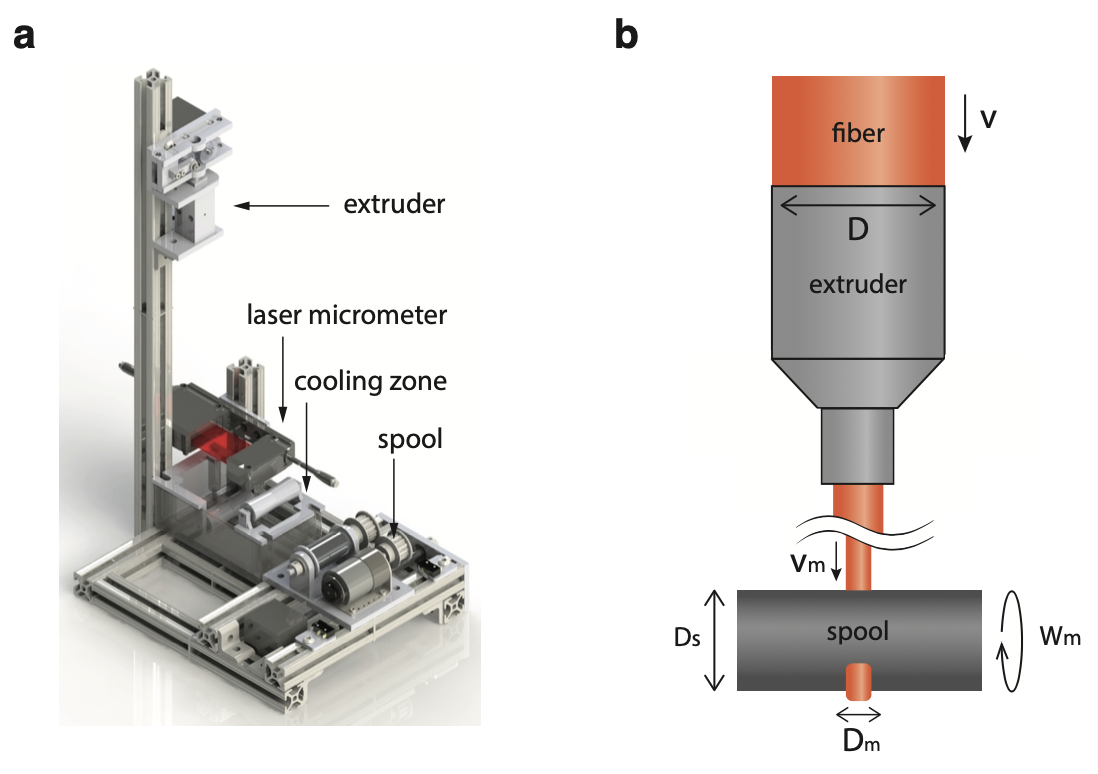

In [2]:
Image('./fred.png', width = 600)

## 2. Signature of machine failure
> At normal conditions, the FrED user can expect the output fiber to be within the tolerance range of 10 %. However, as the machine goes through series of operations, the component with the most dynamic movement (rotation) – the spool – gets worn. The consequence of such degradation of the spool is that the output fiber diameter will deviate from the tolerance range. In the case of FrED, a new spool and a worn spool can be readily distinguished by comparing the frequency signature of the machine’s measured spool velocity (W_m).

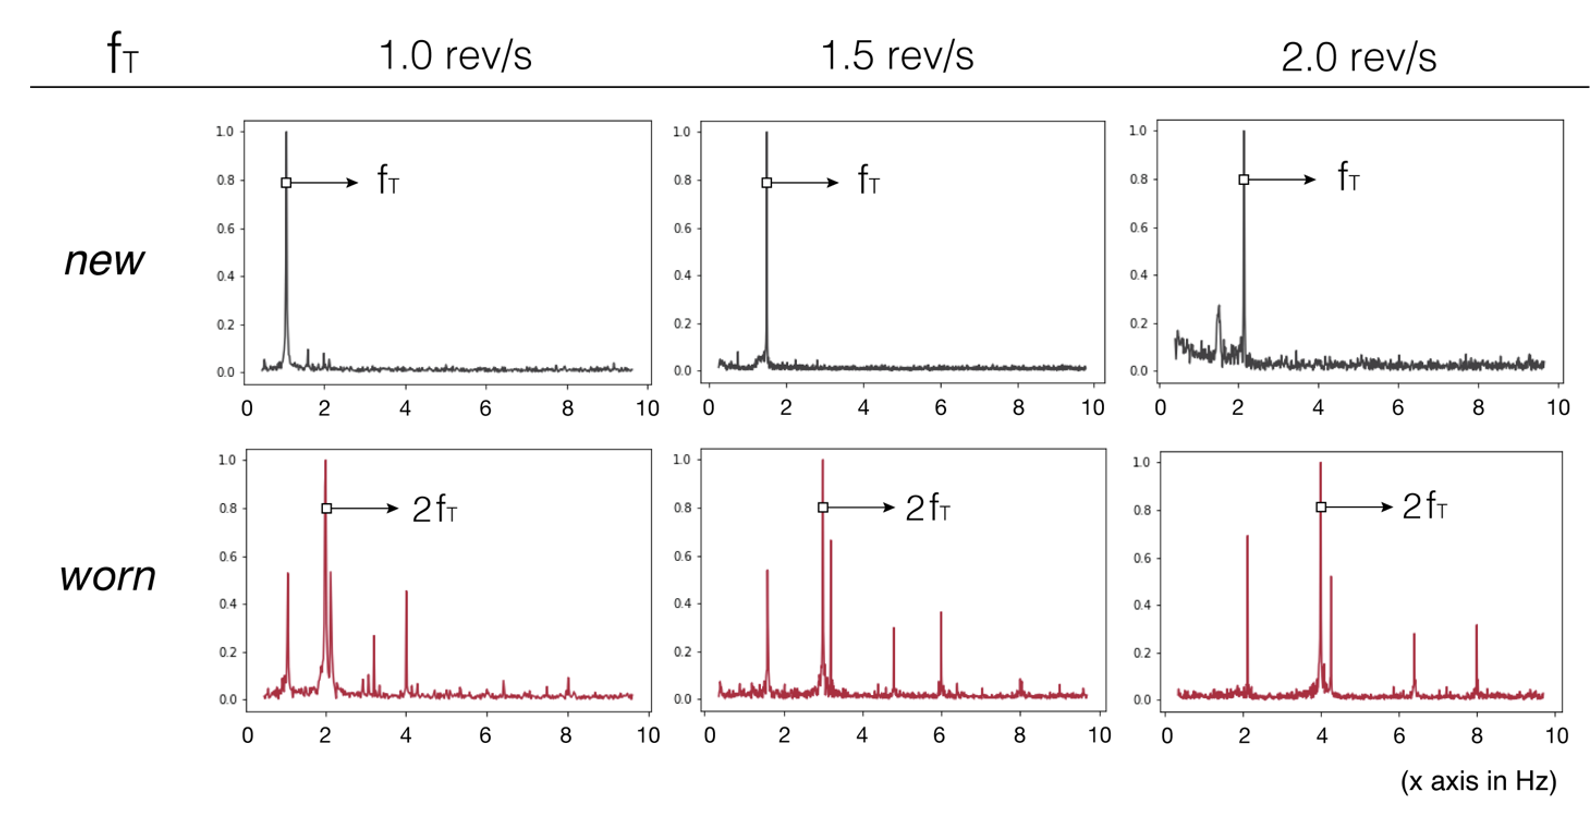

In [3]:
Image('./f-chars.png', width = 800)

## 3. Bit-reversed DFT matrices

> To extract DFT matrices ourselves in a way that encrypted time series data can be transformed successfully into frequency data, we take advantage of [Cheon et. al 2018](https://eprint.iacr.org/2018/1073.pdf)'s paper and how it can be expanded to studies like ours!

### 3.1. Bit-reversed freq. info

In [4]:
def bit_rev_arr(array): # only takes array with length of pow of 2

    n = len(array)  ## say array length = 128
    bit = int(np.log2(n))   ## so bit = 7
    
    result = np.zeros(n)
    
    for i in range(0, n):
        
        # mapping i to i_prime
        binary_expression_of_i = bin(i)[2:]
        deficit_digit = bit - len(binary_expression_of_i)
        aux_zeros = np.zeros(deficit_digit, dtype=int).tolist()
        temp = "".join(str(x) for x in aux_zeros) + binary_expression_of_i
        final_string = '0b' + temp[::-1] # adding the 0b (binary formulation) to the reversed bit
        i_prime = int(final_string, 2) # converting final_string into binary (2) expression
        
        result[i_prime] = array[i]
        
    return result

def r_bit_rev_mat(array): # row bit reversed matrix (only takes array with length of pow of 2)

    n = len(array)  
    bit = int(np.log2(n))
    
    result = np.zeros(n**2, dtype = 'complex_').reshape(n,n)
    
    for i in range(0, n):
        
        # mapping i to i_prime
        binary_expression_of_i = bin(i)[2:]
        deficit_digit = bit - len(binary_expression_of_i)
        aux_zeros = np.zeros(deficit_digit, dtype=int).tolist()
        temp = "".join(str(x) for x in aux_zeros) + binary_expression_of_i
        final_string = '0b' + temp[::-1] # adding the 0b (binary formulation) to the reversed bit
        i_prime = int(final_string, 2) # converting final_string into binary (2) expression
        
        result[i_prime] = array[i]
        
    return result

def c_bit_rev_mat(array): # column bit reversed matrix (only takes array with length of pow of 2)
    return np.transpose(r_bit_rev_mat(np.transpose(array)))

def rc_bit_rev_mat(array):
    return c_bit_rev_mat(r_bit_rev_mat(array))

### 3.2. bit-reversed DFT matrix

In [5]:
def A(w,p,r):
    left_top = np.identity(2**(p-r))
    right_top = left_top
    left_bottom = np.diag(np.geomspace(1, w**(2**(p-r)-1), num = 2**(p-r)))
    right_bottom = -left_bottom
        
    return np.block([[left_top, right_top], [left_bottom, right_bottom]])

def D(n,k): ## say n = 2^p, k = 2^r
    p = int(np.log2(n)) 
    r = int(np.log2(k)) 
    
    theta = - 2*np.pi/(n/(2**(r-1)))
    w = complex(np.cos(theta),np.sin(theta))
    
    A_block = A(w,p,r)
    
    for i in range(1, r): ## i = 1 ~ r-1
        zeros = np.zeros((  (2**(p-r))*(2**i)  ,  (2**(p-r))*(2**i)     ))
        A_block = np.block([ [A_block, zeros], [zeros, A_block] ])
        
    return A_block  

def DFT(n): 
    result = D(n,2)

    for i in range(1,int(np.log2(n))):
        k = 2**(i+1)
        result = np.dot(D(n,k),result)
        
    return result ## returns bit-reversed DFT matrix

### 3.3. Save D real & complex D matrices

In [6]:
def D_save_real(n):
    p = int(np.log2(n))

    D_a = np.ravel(rc_bit_rev_mat(D(n,2))) # array
    D_s = pd.Series(D_a.real) # series - extracting reals
    D_df_raw = pd.DataFrame(D_s, columns = ['value']) # data frame
    adjusted = D_df_raw['value'].apply(lambda x : 0.0001 if x == 0 else x) # adding little noise to avoid transparent ctext
    D_df = pd.DataFrame(adjusted).T # final data frame
    
    for i in range(1,p):
        k = 2**(i+1)
        D_a = np.ravel(rc_bit_rev_mat(D(n,k))) # array
        D_s = pd.Series(D_a.real) # series - extracting reals
        D_df_raw = pd.DataFrame(D_s, columns = ['value']) # data frame
        adjusted = D_df_raw['value'].apply(lambda x : 0.00001 if x == 0 else x) # adding little noise to avoid transparent ctext
        temp = pd.DataFrame(adjusted).T # final data frame
        D_df = D_df.append(temp, ignore_index = True) 
        
    D_df.to_csv('fft_D_real_N1024_paper.csv', index = False)
    
def D_save_imag(n):
    p = int(np.log2(n))
    
    D_a = np.ravel(rc_bit_rev_mat(D(n,2))) # array
    D_s = pd.Series(D_a.imag) # series - extracting imaginaries
    D_df_raw = pd.DataFrame(D_s, columns = ['value']) # data frame
    adjusted = D_df_raw['value'].apply(lambda x : 0.0001 if x == 0 else x) # adding little noise to avoid transparent ctext
    D_df = pd.DataFrame(adjusted).T # final data frame
    
    for i in range(1,p):
        k = 2**(i+1)
        D_a = np.ravel(rc_bit_rev_mat(D(n,k))) # array
        D_s = pd.Series(D_a.imag) # series - extracting imaginaries
        D_df_raw = pd.DataFrame(D_s, columns = ['value']) # data frame
        adjusted = D_df_raw['value'].apply(lambda x : 0.00001 if x == 0 else x) # adding little noise to avoid transparent ctext
        temp = pd.DataFrame(adjusted).T # final data frame
        D_df = D_df.append(temp, ignore_index = True) 
        
    D_df.to_csv('fft_D_imag_N1024_paper.csv', index = False)

## 4. H-FFT algorithm

> In our study, we used [Microsoft's SEAL library](https://www.microsoft.com/en-us/research/project/microsoft-seal/) (MIT license) in C++ to compute FFT on encrypted data using the D matrices obtained above. Thanks to the great staffs at MSFT who helped facilitate good discussions and bug fixes.

### 4.1. H-FFT output from unhealthy FrED

In [7]:
# pd.DataFrame(c_real).to_csv('c_real_unhealthy.csv')
c_real_unhealthy = pd.read_csv('./c_real_unhealthy.csv')

# pd.DataFrame(c_real).to_csv('c_imag_unhealthy.csv')
c_imag_unhealthy = pd.read_csv('./c_imag_unhealthy.csv')

c_real = c_real_unhealthy.iloc[:,1].values
c_imag = c_imag_unhealthy.iloc[:,1].values

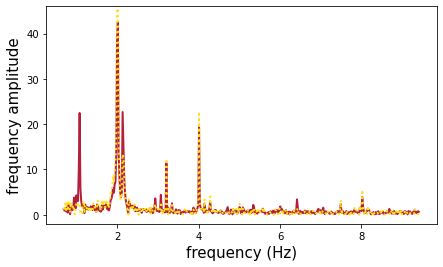

In [8]:
Fs = 20
size = 1024

input_01 = pd.read_excel("../../data/01_C.xlsx")['Spool Rev/Sec - Measured Velocity'].values

y = fft(input_01)
y_he = np.sqrt(c_real**2 + c_imag**2)
x = np.linspace(0, Fs//2, size//2)

fig, ax1 = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(7,4)

ax1.plot(x[35:-30], np.abs(y[35:size//2-30]), color='#B51F3B', linestyle='solid', lw = 2, label = 'FFT') 
ax1.plot(x[35:-30], y_he[35:size//2-30], color='#FFE115', linestyle='dotted', lw = 2, label = 'Hom. FFT')

ax1.set_xlabel('frequency (Hz)', size = 15)
ax1.set_ylabel ('frequency amplitude', size = 15)
# ax1.legend(bbox_to_anchor = (0.95, 0.93), prop={'size': 15})
ax1.set_ylim(-2, 46)

plt.savefig('fig3_01_C_accuracy.png')

prognostics_result = np.array([-0.842806, -0.838365, -0.752189, 0.622249, 0.868162, -0.758075, -0.831792, -0.854308]) # Success!

<div class="alert alert-block alert-success">
<b>Success:</b> This confirms that our server successfully extracted the frequency signature from an unhealthy FrED while being completely blind to the client's data!
</div>

### 4.2. H-FFT output from healthy FrED

In [9]:
# pd.DataFrame(c_real).to_csv('c_real_healthy.csv')
c_real_healthy = pd.read_csv('./c_real_healthy.csv')

# pd.DataFrame(c_real).to_csv('c_imag_healthy.csv')
c_imag_healthy = pd.read_csv('./c_imag_healthy.csv')

c_real = c_real_healthy.iloc[:,1].values
c_imag = c_imag_healthy.iloc[:,1].values

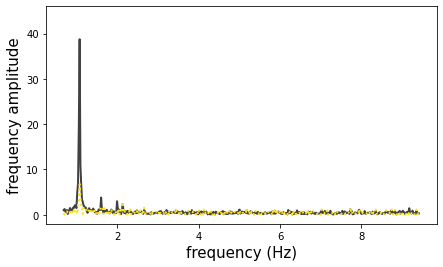

In [10]:
input_06 = pd.read_excel("../../data/06_C.xlsx")['Spool Rev/Sec - Measured Velocity'].values

y = fft(input_06)
y_he = np.sqrt(c_real**2 + c_imag**2)
x = np.linspace(0, Fs//2, size//2)

fig, ax1 = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(7,4)

ax1.plot(x[35:-30], np.abs(y[35:size//2-30]), color='#414042', linestyle='solid', lw = 2, label = 'FFT') 
ax1.plot(x[35:-30], y_he[35:size//2-30], color='#FFE115', linestyle='dotted', lw = 2, label = 'Hom. FFT')

ax1.set_xlabel('frequency (Hz)', size = 15)
ax1.set_ylabel ('frequency amplitude', size = 15)
# ax1.legend(bbox_to_anchor = (0.95, 0.93), prop={'size': 15})
ax1.set_ylim(-2, 46)

plt.savefig('fig3_06_C_accuracy.png')

prognostics_result = np.array([-0.866909, -0.866875, -0.867052, -0.863182, -0.865872, -0.866014, -0.866834, -0.866662]) # Success!

<div class="alert alert-block alert-success">
<b>Success:</b> This confirms that our server successfully extracted the frequency signature from a healthy FrED while being completely blind to the client's data!
</div>

> In summary, as shown below, our H-FFT algorithm can extract client's machine frequency information in a provacy-protected fashion without the sacrifice of data accuracy unlike the case of randomization techniques.

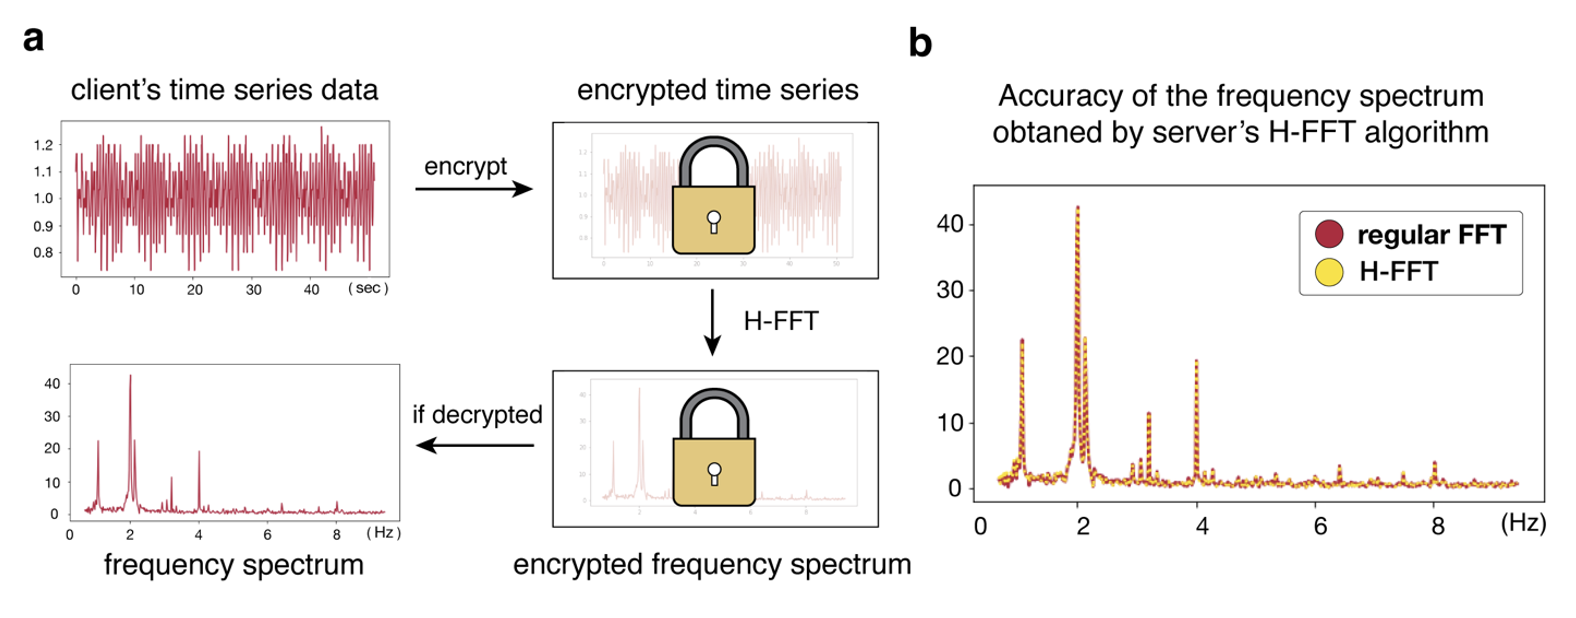

In [11]:
Image('./he-fft.png', width = 900)

## 5. H-C algorithm

> Incorporation of the H-C algorithm proposed by [Cheon. et al (2020)](https://link.springer.com/chapter/10.1007/978-3-030-64834-3_8) extends our capability even further to detect the presence of frequency peaks and output a prescription message in an encrypted format. The client, upon decryption using its secret key, may follow the prescription to renew system health.

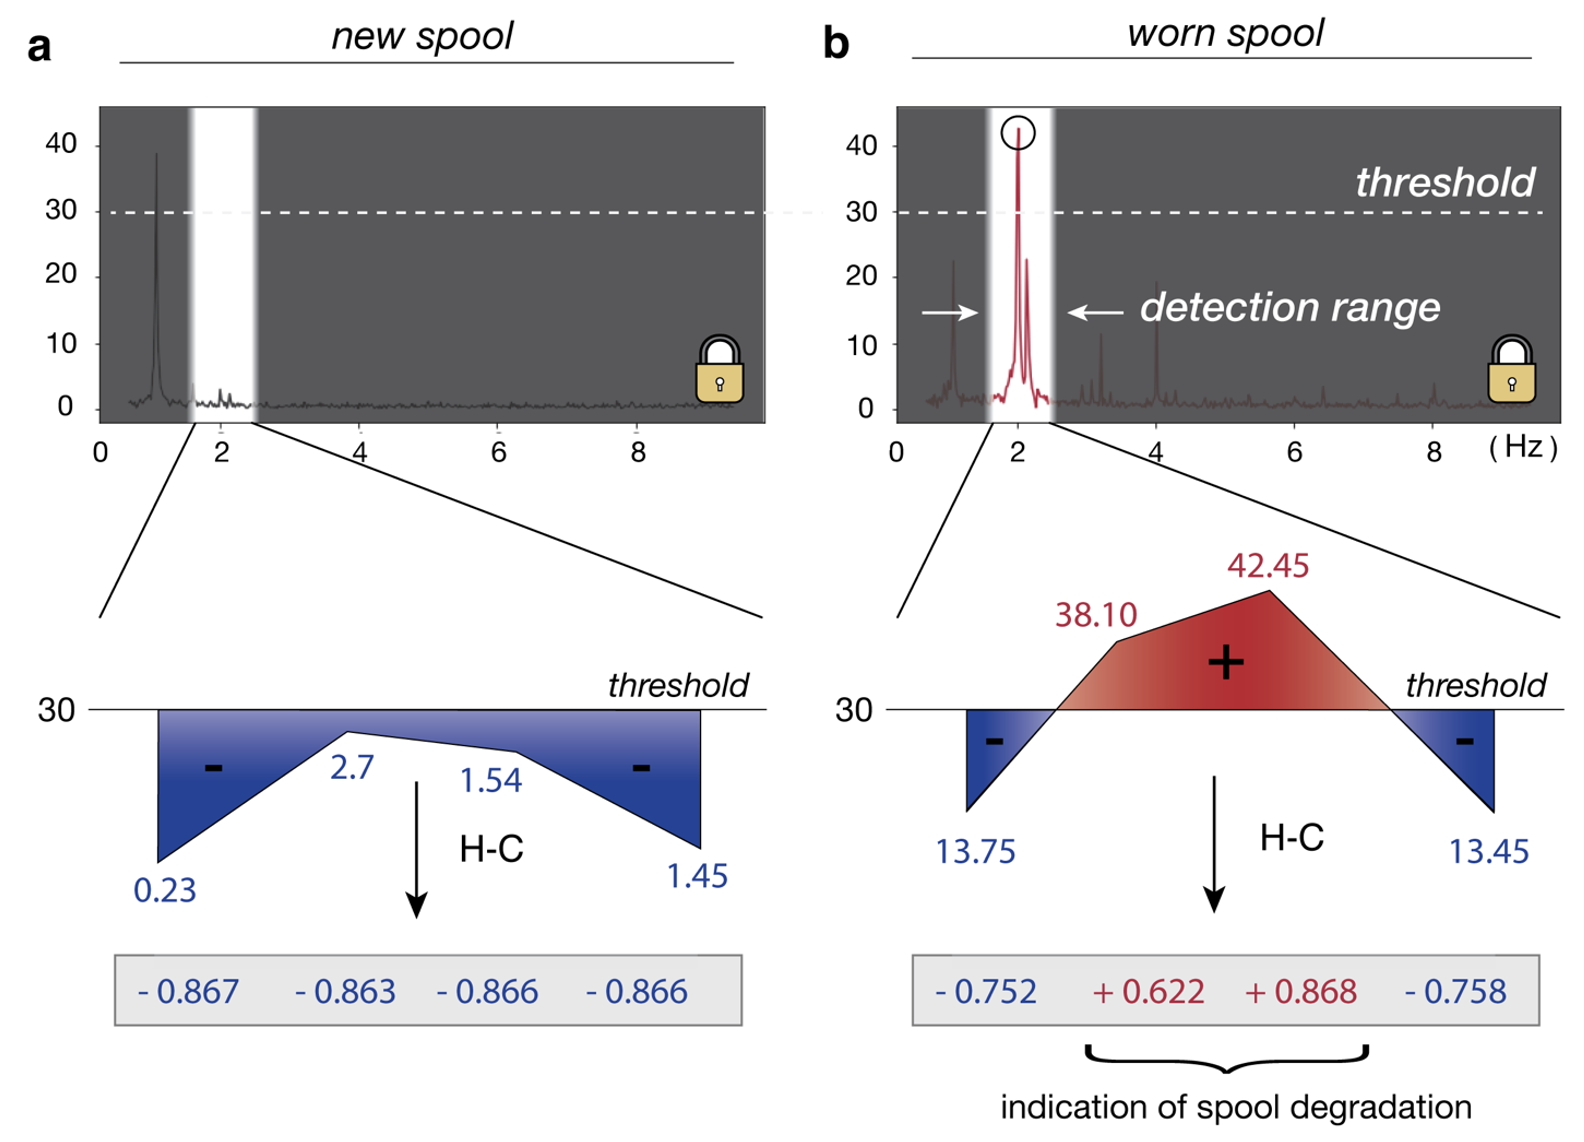

In [12]:
Image('./he-c.png', width = 800)

## 6. In a nutshell
> We are excited to have introduced in out paper a frequency-based peak detection algorithm (H-FFT-C) that generates a machine health diagnosis and prescription report, while keeping the machine data private. We demonstrate the secure PHM outsourcing scenario on a lab-scale fiber extrusion device called FrED, and our demonstration is comprised of key functionalities found in many PHM (Prognotics and Health Management) applications, much required in the new Industry 4.0 era. <br>

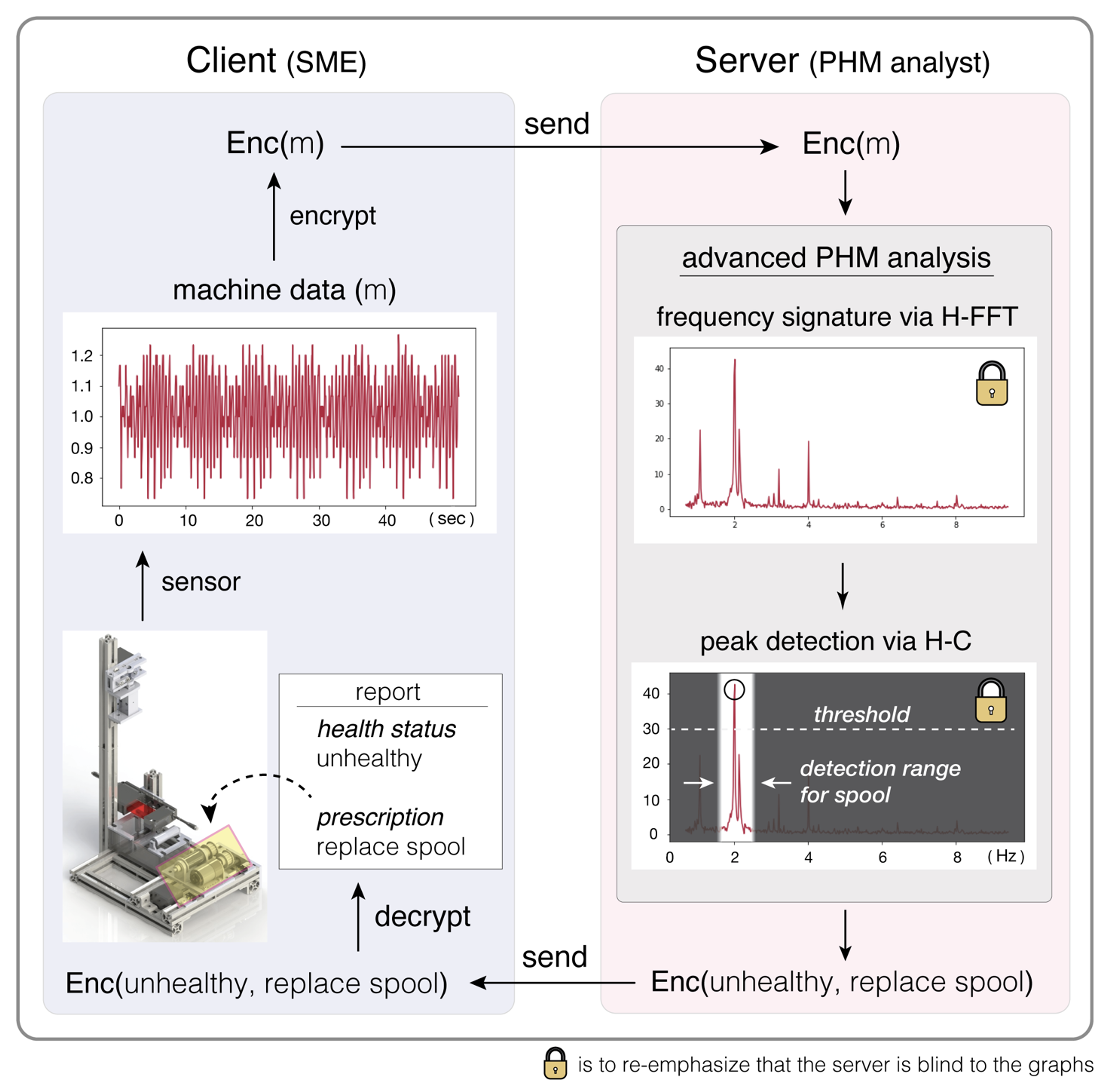

In [13]:
Image('./summary.png', width = 700)

> Stay tuned! Our future studies will considuer much divere set of applications and introduce how the use of Privacy-Protected Machine Learning can accelerate the safe and reliable creation of data sharing economy in the Industry 4.0 era.